### Read the data from the input Excel file

In [1]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
inputFileName = "TransportationPb_Data.xlsx"
paramDF = pd.read_excel(inputFileName, "Param", skiprows=0)
supplyDF = pd.read_excel(inputFileName, "Supply", skiprows=0, index_col=0)
demandDF = pd.read_excel(inputFileName, "Demand", skiprows=0, index_col=0)
freightDF = pd.read_excel(inputFileName, "Freight", skiprows=0, index_col=2)


### Set the data into dict, easier to manipulate

In [3]:
plants = supplyDF.to_dict('index')
markets = demandDF.to_dict('index')
   

freightCost = {}  #freightCost[iPlant][iMarket]
for index, row in freightDF.iterrows():
    if row['Plant'] not in freightCost : freightCost[row['Plant']] = {}
    freightCost[row['Plant']][row['Market']] = row['Cost']
    

 ### **1.Model the market as if a « big owner » owned all the suppliers and aims at satisfying the demands at least cost . Solve this optimization problem with PuLP**

In [4]:
#Define problem
from pulp import *
prob = LpProblem("Transportation_problem",LpMinimize)

### Add variables


In [5]:
Xvar = LpVariable.dicts("X", ((i,j) for i in plants for j in markets), 
                             lowBound=0, cat='Continuous')
DemandVar= LpVariable.dicts("Demand", (i for i in markets), lowBound=0, cat='Continuous')
CapacityVar= LpVariable.dicts("Capacity", (i for i in plants), lowBound=0, cat='Continuous')


### Add objectives

In [6]:
prob += lpSum([(freightCost[i][j] + plants[i]['Cost'])* Xvar[i,j] for i in plants for j in markets ])

In [7]:
#Notre problème renferme 200 variables Xij, 20 contraintes Capa, 10 contraintes de demand

### Add constraints

In [8]:
#Capacity constraint (for each plant)
for i in (plants) : 
        prob += lpSum(Xvar[i,j] for j in markets) <= plants[i]['Capacity'] , "capacity[%s]"%(i)



In [9]:
# # #Demand constraint
for j in (markets) :
    prob += lpSum(Xvar[i,j] for i in plants) >= markets[j]['Demand'] , "demand[%s]"%(j)

In [10]:
#prob

In [11]:
prob.writeLP("TransportationProblem_primal_mod1.lp", writeSOS=1, mip=1)
prob.solve()
print("Status:", LpStatus[prob.status])
print ("Objective = ", value(prob.objective))
varsDict = {}
for v in prob.variables():
    varsDict[v.name] = v.varValue
    if "X" in v.name:
        print(v.name, "=", v.varValue)
        


Status: Optimal
Objective =  16847.0
X_('P1',_'M1') = 0.0
X_('P1',_'M10') = 0.0
X_('P1',_'M2') = 80.0
X_('P1',_'M3') = 0.0
X_('P1',_'M4') = 0.0
X_('P1',_'M5') = 0.0
X_('P1',_'M6') = 0.0
X_('P1',_'M7') = 0.0
X_('P1',_'M8') = 0.0
X_('P1',_'M9') = 0.0
X_('P10',_'M1') = 0.0
X_('P10',_'M10') = 0.0
X_('P10',_'M2') = 0.0
X_('P10',_'M3') = 2.0
X_('P10',_'M4') = 0.0
X_('P10',_'M5') = 0.0
X_('P10',_'M6') = 0.0
X_('P10',_'M7') = 0.0
X_('P10',_'M8') = 0.0
X_('P10',_'M9') = 0.0
X_('P11',_'M1') = 0.0
X_('P11',_'M10') = 0.0
X_('P11',_'M2') = 44.0
X_('P11',_'M3') = 0.0
X_('P11',_'M4') = 0.0
X_('P11',_'M5') = 0.0
X_('P11',_'M6') = 0.0
X_('P11',_'M7') = 0.0
X_('P11',_'M8') = 0.0
X_('P11',_'M9') = 12.0
X_('P12',_'M1') = 0.0
X_('P12',_'M10') = 0.0
X_('P12',_'M2') = 0.0
X_('P12',_'M3') = 0.0
X_('P12',_'M4') = 75.0
X_('P12',_'M5') = 0.0
X_('P12',_'M6') = 0.0
X_('P12',_'M7') = 0.0
X_('P12',_'M8') = 7.0
X_('P12',_'M9') = 8.0
X_('P13',_'M1') = 0.0
X_('P13',_'M10') = 0.0
X_('P13',_'M2') = 0.0
X_('P13',_'M3') = 

###**2.Use PuLP to get the dual variables. Why does it make sense to interpret the dual variables associated with the Demand constraints as prices**

In [12]:
#Le nombre de variables du pb dual = nb de contraintes du primal
#Le nb de contraintes du pb dual = nb de variables du primal

In [13]:
for name, c in list(prob.constraints.items()):
     if "capacity" in name or "demand" in name:
        print(name, ":", c.pi, "\t\t", c.slack)

capacity_P1_ : -14.0 		 -0.0
capacity_P2_ : -21.0 		 -0.0
capacity_P3_ : 0.0 		 11.0
capacity_P4_ : 0.0 		 -0.0
capacity_P5_ : -10.0 		 -0.0
capacity_P6_ : -20.0 		 -0.0
capacity_P7_ : -23.0 		 -0.0
capacity_P8_ : -9.0 		 -0.0
capacity_P9_ : 0.0 		 53.0
capacity_P10_ : -18.0 		 -0.0
capacity_P11_ : -22.0 		 -0.0
capacity_P12_ : -3.0 		 -0.0
capacity_P13_ : -2.0 		 -0.0
capacity_P14_ : -7.0 		 -0.0
capacity_P15_ : 0.0 		 15.0
capacity_P16_ : -16.0 		 -0.0
capacity_P17_ : -6.0 		 -0.0
capacity_P18_ : -8.0 		 -0.0
capacity_P19_ : -7.0 		 -0.0
capacity_P20_ : -11.0 		 -0.0
demand_M1_ : 29.0 		 -0.0
demand_M2_ : 31.0 		 -0.0
demand_M3_ : 30.0 		 -0.0
demand_M4_ : 26.0 		 -0.0
demand_M5_ : 29.0 		 -0.0
demand_M6_ : 29.0 		 -0.0
demand_M7_ : 29.0 		 -0.0
demand_M8_ : 29.0 		 -0.0
demand_M9_ : 29.0 		 -0.0
demand_M10_ : 29.0 		 -0.0


In [14]:
#==> Dans le problème Dual, on adopte une autre stratégie pour voir le problème
#primal : point de vue production :on veut minimiser le cout (transport+production)
#dual : point de vue Gain  : on veut maximiser les marges, il s'agit donc de prix
# (quels impacts quand on durcit les contraintes : couts marginaux)

###**3- Observe that for the obtained price , the obtained flows are such that each supplier is maximising its margin**







In [15]:
#Le modèle cherche à se positionner sur le cout de transport minimum pour chaque supplier
#(le min global du modèle ~ tous les min locaux de chaque supplier)
#==> tout le monde est satisfait (capacité saturée)

<ipython-input-16-d680647ee78d>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myArray = np.zeros((len(plants), len(markets)), dtype=np.float)


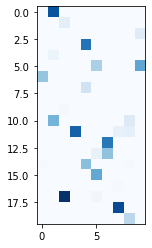

[[ 0. 80.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  0. 69.  0.  0.  0.  0.  0.]
 [ 0.  5.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 31.  0.  0.  0. 50.]
 [37.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 18.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 44.  0.  0.  0.  0.  0.  0. 12.  0.]
 [ 0.  0.  0. 75.  0.  0.  0.  7.  8.  0.]
 [ 0.  0.  0.  0.  0.  0. 67.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  7. 38.  0.  0.  0.]
 [ 1.  0.  0.  0. 39.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. 49.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. 93.  0.  0.  3.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 83.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 26.  0.]]


In [16]:
import matplotlib.pyplot as plt 
import numpy as np

myArray = np.zeros((len(plants), len(markets)), dtype=np.float)


for i,p in enumerate(plants):
    for j,m in enumerate(markets): 
        myArray[i][j] = varsDict["X_(\'%s\',_\'%s\')" %(p, m)]
plt.imshow(myArray, cmap='Blues', interpolation='nearest')
plt.show()
print(myArray)

In [17]:
calc_list =list()
capa_list=list()
for i,p in enumerate(plants):
    calc=0
    capa_list.append(plants[p]['Capacity'])
    for j,m in enumerate(markets): 
      calc=calc+myArray[i,j]
  # list[i]=i
    print(calc)
    calc_list.append(calc)



80.0
9.0
11.0
69.0
5.0
81.0
37.0
18.0
0.0
2.0
56.0
90.0
67.0
45.0
41.0
49.0
1.0
96.0
83.0
26.0


In [18]:
print(calc_list)
print(capa_list)
boolean_list=list()
for i in range(len(calc_list)):
  boolean_list.append(calc_list[i]==capa_list[i])

print(boolean_list)

[80.0, 9.0, 11.0, 69.0, 5.0, 81.0, 37.0, 18.0, 0.0, 2.0, 56.0, 90.0, 67.0, 45.0, 41.0, 49.0, 1.0, 96.0, 83.0, 26.0]
[80, 9, 22, 69, 5, 81, 37, 18, 53, 2, 56, 90, 67, 45, 56, 49, 1, 96, 83, 26]
[True, True, False, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True]


In [19]:
dataframe = pd.DataFrame(
    {'calculated': calc_list,
     'capacity': capa_list,
     'boolean': boolean_list
    })

print(dataframe)

    calculated  capacity  boolean
0         80.0        80     True
1          9.0         9     True
2         11.0        22    False
3         69.0        69     True
4          5.0         5     True
5         81.0        81     True
6         37.0        37     True
7         18.0        18     True
8          0.0        53    False
9          2.0         2     True
10        56.0        56     True
11        90.0        90     True
12        67.0        67     True
13        45.0        45     True
14        41.0        56    False
15        49.0        49     True
16         1.0         1     True
17        96.0        96     True
18        83.0        83     True
19        26.0        26     True


In [20]:
calc_list =list()
for i,p in enumerate(plants):
    val=0
    for j,m in enumerate(markets): 
      val=val+(freightCost[p][m] + plants[p]['Cost'])*myArray[i,j]
  # list[i]=i
    print(val)
    calc_list.append(val)
print(calc_list)

1360.0
81.0
319.0
2001.0
105.0
729.0
222.0
360.0
0.0
24.0
480.0
2115.0
1809.0
990.0
1189.0
637.0
23.0
2109.0
1826.0
468.0
[1360.0, 81.0, 319.0, 2001.0, 105.0, 729.0, 222.0, 360.0, 0.0, 24.0, 480.0, 2115.0, 1809.0, 990.0, 1189.0, 637.0, 23.0, 2109.0, 1826.0, 468.0]


In [21]:
sum(calc_list)

16847.0

###**4- Impose a constraint stating that a supplier shall have not more than 50% of market share on any market . What is the impact on the prices ?**

In [22]:
# # #New constraint 
for i in (plants) :
  for j in (markets) :
    prob += Xvar[i,j] <= 0.5 * markets[j]['Demand'],"New_constraint plant[%s] market[%s]"%(i,j)

In [23]:
# prob

In [24]:
prob.writeLP("transportationProblem_primal_mod2.lp", writeSOS=1, mip=1)
prob.solve()
print("Status:", LpStatus[prob.status])
print("Objective =", value(prob.objective))
varsDict = {}
for v in prob.variables():
    varsDict[v.name] = v.varValue
    if "X" in v.name:
        print(v.name, "=", v.varValue)

Status: Optimal
Objective = 16990.0
X_('P1',_'M1') = 0.0
X_('P1',_'M10') = 0.0
X_('P1',_'M2') = 64.5
X_('P1',_'M3') = 0.0
X_('P1',_'M4') = 0.0
X_('P1',_'M5') = 0.0
X_('P1',_'M6') = 0.0
X_('P1',_'M7') = 0.0
X_('P1',_'M8') = 15.5
X_('P1',_'M9') = 0.0
X_('P10',_'M1') = 0.0
X_('P10',_'M10') = 0.0
X_('P10',_'M2') = 0.0
X_('P10',_'M3') = 2.0
X_('P10',_'M4') = 0.0
X_('P10',_'M5') = 0.0
X_('P10',_'M6') = 0.0
X_('P10',_'M7') = 0.0
X_('P10',_'M8') = 0.0
X_('P10',_'M9') = 0.0
X_('P11',_'M1') = 0.0
X_('P11',_'M10') = 0.0
X_('P11',_'M2') = 52.5
X_('P11',_'M3') = 0.0
X_('P11',_'M4') = 0.0
X_('P11',_'M5') = 0.0
X_('P11',_'M6') = 0.0
X_('P11',_'M7') = 0.0
X_('P11',_'M8') = 0.0
X_('P11',_'M9') = 3.5
X_('P12',_'M1') = 0.0
X_('P12',_'M10') = 0.0
X_('P12',_'M2') = 0.0
X_('P12',_'M3') = 0.0
X_('P12',_'M4') = 37.5
X_('P12',_'M5') = 0.0
X_('P12',_'M6') = 0.0
X_('P12',_'M7') = 7.5
X_('P12',_'M8') = 21.5
X_('P12',_'M9') = 23.5
X_('P13',_'M1') = 0.0
X_('P13',_'M10') = 0.0
X_('P13',_'M2') = 0.0
X_('P13',_'M3') =

In [25]:
print((prob.objective))

19*X_('P1',_'M1') + 22*X_('P1',_'M10') + 17*X_('P1',_'M2') + 18*X_('P1',_'M3') + 19*X_('P1',_'M4') + 22*X_('P1',_'M5') + 16*X_('P1',_'M6') + 17*X_('P1',_'M7') + 15*X_('P1',_'M8') + 16*X_('P1',_'M9') + 13*X_('P10',_'M1') + 16*X_('P10',_'M10') + 14*X_('P10',_'M2') + 12*X_('P10',_'M3') + 16*X_('P10',_'M4') + 18*X_('P10',_'M5') + 17*X_('P10',_'M6') + 14*X_('P10',_'M7') + 14*X_('P10',_'M8') + 18*X_('P10',_'M9') + 14*X_('P11',_'M1') + 10*X_('P11',_'M10') + 9*X_('P11',_'M2') + 13*X_('P11',_'M3') + 13*X_('P11',_'M4') + 10*X_('P11',_'M5') + 12*X_('P11',_'M6') + 14*X_('P11',_'M7') + 12*X_('P11',_'M8') + 7*X_('P11',_'M9') + 29*X_('P12',_'M1') + 26*X_('P12',_'M10') + 30*X_('P12',_'M2') + 32*X_('P12',_'M3') + 23*X_('P12',_'M4') + 28*X_('P12',_'M5') + 28*X_('P12',_'M6') + 27*X_('P12',_'M7') + 26*X_('P12',_'M8') + 26*X_('P12',_'M9') + 34*X_('P13',_'M1') + 32*X_('P13',_'M10') + 32*X_('P13',_'M2') + 31*X_('P13',_'M3') + 35*X_('P13',_'M4') + 33*X_('P13',_'M5') + 27*X_('P13',_'M6') + 27*X_('P13',_'M7') +

In [26]:
for name, c in list(prob.constraints.items()):
     if "capacity" in name or "demand" in name:
        print(name, ":", c.pi, "\t\t", c.slack)

capacity_P1_ : -14.0 		 -0.0
capacity_P2_ : -21.0 		 -0.0
capacity_P3_ : 0.0 		 20.0
capacity_P4_ : 0.0 		 6.0
capacity_P5_ : -10.0 		 -0.0
capacity_P6_ : -18.0 		 -0.0
capacity_P7_ : -23.0 		 -0.0
capacity_P8_ : -9.0 		 -0.0
capacity_P9_ : 0.0 		 53.0
capacity_P10_ : -18.0 		 -0.0
capacity_P11_ : -22.0 		 -0.0
capacity_P12_ : -3.0 		 -0.0
capacity_P13_ : -1.0 		 -0.0
capacity_P14_ : -8.0 		 -0.0
capacity_P15_ : 0.0 		 -0.0
capacity_P16_ : -14.0 		 -0.0
capacity_P17_ : -6.0 		 -0.0
capacity_P18_ : -6.0 		 -0.0
capacity_P19_ : -7.0 		 -0.0
capacity_P20_ : -11.0 		 -0.0
demand_M1_ : 29.0 		 -0.0
demand_M2_ : 31.0 		 -0.0
demand_M3_ : 30.0 		 -0.0
demand_M4_ : 28.0 		 -0.0
demand_M5_ : 29.0 		 -0.0
demand_M6_ : 27.0 		 -0.0
demand_M7_ : 30.0 		 -0.0
demand_M8_ : 29.0 		 -0.0
demand_M9_ : 29.0 		 -0.0
demand_M10_ : 27.0 		 -0.0


In [27]:
#obj = 16847 (old) ==> new : Objective =  16990.0
#demand_M1_ : 29.0 		 -0.0
#demand_M2_ : 31.0 		 -0.0
#demand_M3_ : 30.0 		 -0.0
#demand_M4_ : 26.0 		 -0.0
#demand_M5_ : 29.0 		 -0.0
#demand_M6_ : 29.0 		 -0.0
#demand_M7_ : 29.0 		 -0.0
#demand_M8_ : 29.0 		 -0.0
#demand_M9_ : 29.0 		 -0.0
#demand_M10_ : 29.0 

###**5.Write the dual of the problem , and solve it with PuLP . Check that the value of the variables are the same that what was obtained with the primal**

In [28]:
B=[markets[j]['Demand'] for j in markets]+[plants[i]['Capacity'] for i in plants]
print(B)


[38, 129, 104, 75, 126, 90, 105, 91, 47, 61, 80, 9, 22, 69, 5, 81, 37, 18, 53, 2, 56, 90, 67, 45, 56, 49, 1, 96, 83, 26]


In [29]:
import numpy as np

A=np.zeros((30,230))
k=0
for i in range(10) :
        for j in range(20):
            A[i,j*10+k]=1.0
        k+=1
        
for i in range(10) :
    A[i,i+200]=-1.

for i in range(20) :
        for j in range(10):
            A[i+10,i*10+j]=1.0
        
for i in range(20) :
    A[i+10,i+210]=1.0
print(A)
tA=A.transpose()

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [30]:
C=[freightCost[i][j] + plants[i]['Cost'] for i in plants for j in markets ]+[0]*30
print(C)

[19, 17, 18, 19, 22, 16, 17, 15, 16, 22, 17, 17, 9, 18, 10, 12, 13, 15, 10, 11, 30, 34, 36, 30, 29, 37, 33, 34, 31, 29, 31, 34, 36, 36, 29, 31, 32, 36, 33, 34, 27, 21, 25, 22, 21, 22, 22, 29, 26, 21, 15, 17, 17, 17, 12, 9, 13, 12, 11, 9, 6, 12, 14, 15, 11, 14, 12, 6, 14, 10, 26, 23, 24, 26, 20, 21, 27, 26, 28, 24, 35, 33, 31, 30, 35, 33, 35, 30, 36, 33, 13, 14, 12, 16, 18, 17, 14, 14, 18, 16, 14, 9, 13, 13, 10, 12, 14, 12, 7, 10, 29, 30, 32, 23, 28, 28, 27, 26, 26, 26, 34, 32, 31, 35, 33, 27, 27, 30, 28, 32, 27, 27, 23, 20, 28, 22, 22, 25, 23, 24, 29, 35, 33, 32, 29, 32, 33, 32, 29, 33, 19, 17, 21, 17, 17, 13, 21, 17, 19, 13, 28, 25, 26, 24, 28, 29, 31, 23, 24, 26, 23, 27, 22, 23, 24, 21, 24, 23, 24, 26, 24, 24, 23, 22, 23, 28, 28, 22, 29, 29, 21, 25, 24, 18, 19, 22, 19, 25, 18, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
prob2 = LpProblem("Transportation_problem_dual",LpMaximize)

In [32]:
Xvar2=LpVariable.dict("dual", (i for i in range(30)), lowBound=None, cat='Continuous')
print(Xvar2[1])

dual_1


In [33]:
prob2+= lpSum(Xvar2[i]*B[i] for i in Xvar2.keys())
for i in range(len(tA)) :
    K=[]
    for j in range(30):
        K+=Xvar2[j]*tA[i][j]
        print(j)
    prob2+= lpSum(K)<=C[i],"constraint [%s]]"%(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

In [34]:
print(prob2)

Transportation_problem_dual:
MAXIMIZE
38*dual_0 + 129*dual_1 + 80*dual_10 + 9*dual_11 + 22*dual_12 + 69*dual_13 + 5*dual_14 + 81*dual_15 + 37*dual_16 + 18*dual_17 + 53*dual_18 + 2*dual_19 + 104*dual_2 + 56*dual_20 + 90*dual_21 + 67*dual_22 + 45*dual_23 + 56*dual_24 + 49*dual_25 + 1*dual_26 + 96*dual_27 + 83*dual_28 + 26*dual_29 + 75*dual_3 + 126*dual_4 + 90*dual_5 + 105*dual_6 + 91*dual_7 + 47*dual_8 + 61*dual_9 + 0
SUBJECT TO
constraint__0__: dual_0 + dual_10 <= 19

constraint__1__: dual_1 + dual_10 <= 17

constraint__2__: dual_10 + dual_2 <= 18

constraint__3__: dual_10 + dual_3 <= 19

constraint__4__: dual_10 + dual_4 <= 22

constraint__5__: dual_10 + dual_5 <= 16

constraint__6__: dual_10 + dual_6 <= 17

constraint__7__: dual_10 + dual_7 <= 15

constraint__8__: dual_10 + dual_8 <= 16

constraint__9__: dual_10 + dual_9 <= 22

constraint__10__: dual_0 + dual_11 <= 17

constraint__11__: dual_1 + dual_11 <= 17

constraint__12__: dual_11 + dual_2 <= 9

constraint__13__: dual_11 + dual_3

In [35]:
prob2.writeLP("TransportationProblem_dual.lp", writeSOS=1, mip=1)
prob2.solve()
print("Status:", LpStatus[prob2.status])
print("Objective = ", value(prob2.objective))
varsDict = {}

for v in prob2.variables():
    varsDict[v.name] = v.varValue
    if "dual" in v.name:
        print(v.name, "=", v.varValue)

Status: Optimal
Objective =  16846.999999999945
dual_0 = 29.0
dual_1 = 31.0
dual_10 = -14.0
dual_11 = -21.0
dual_12 = 0.0
dual_13 = 0.0
dual_14 = -10.0
dual_15 = -20.0
dual_16 = -23.0
dual_17 = -9.0
dual_18 = 0.0
dual_19 = -18.0
dual_2 = 30.0
dual_20 = -22.0
dual_21 = -3.0
dual_22 = -2.0
dual_23 = -7.0
dual_24 = -9.9831254e-13
dual_25 = -16.0
dual_26 = -6.0
dual_27 = -8.0
dual_28 = -7.0
dual_29 = -11.0
dual_3 = 26.0
dual_4 = 29.0
dual_5 = 29.0
dual_6 = 29.0
dual_7 = 29.0
dual_8 = 29.0
dual_9 = 29.0


In [36]:
print(prob2.objective)
print(type(prob2.objective))
value(prob2.objective)


38*dual_0 + 129*dual_1 + 80*dual_10 + 9*dual_11 + 22*dual_12 + 69*dual_13 + 5*dual_14 + 81*dual_15 + 37*dual_16 + 18*dual_17 + 53*dual_18 + 2*dual_19 + 104*dual_2 + 56*dual_20 + 90*dual_21 + 67*dual_22 + 45*dual_23 + 56*dual_24 + 49*dual_25 + dual_26 + 96*dual_27 + 83*dual_28 + 26*dual_29 + 75*dual_3 + 126*dual_4 + 90*dual_5 + 105*dual_6 + 91*dual_7 + 47*dual_8 + 61*dual_9
<class 'pulp.pulp.LpAffineExpression'>


16846.999999999945

In [37]:
prob2.writeLP("TransportationProblem_dual.lp", writeSOS=1, mip=1)
prob2.solve()
print("Status:", LpStatus[prob2.status])
print("Objective = ", value(prob2.objective))
varsDict = {}

for v in prob2.variables():
    varsDict[v.name] = v.varValue
    if "dual" in v.name:
        print(v.name, "=", v.varValue)

Status: Optimal
Objective =  16846.999999999945
dual_0 = 29.0
dual_1 = 31.0
dual_10 = -14.0
dual_11 = -21.0
dual_12 = 0.0
dual_13 = 0.0
dual_14 = -10.0
dual_15 = -20.0
dual_16 = -23.0
dual_17 = -9.0
dual_18 = 0.0
dual_19 = -18.0
dual_2 = 30.0
dual_20 = -22.0
dual_21 = -3.0
dual_22 = -2.0
dual_23 = -7.0
dual_24 = -9.9831254e-13
dual_25 = -16.0
dual_26 = -6.0
dual_27 = -8.0
dual_28 = -7.0
dual_29 = -11.0
dual_3 = 26.0
dual_4 = 29.0
dual_5 = 29.0
dual_6 = 29.0
dual_7 = 29.0
dual_8 = 29.0
dual_9 = 29.0


weak dualiyy cx >= pb

###**6.Solve the problem by using the strong duality theorem : find the solution by defining both dual variables and constraints , then setting that primal objective = dual objective. Use a dummy objective**

In [38]:
prob3 = LpProblem("strong_duality",LpMinimize)
constante=10
prob3 += constante
for i in range(len(tA)) :
    K=[]
    for j in range(30):
        K+=Xvar2[j]*tA[i][j]
        # print(j)
    prob3+= lpSum(K)<=C[i],"constraint [%s]]"%(i)
    
#Capacity constraint (for each plant)
for i in (plants) : 
        prob3 += lpSum(Xvar[i,j] for j in markets) <= plants[i]['Capacity'] , "capacity[%s]"%(i)

# # #Demand constraint
for j in (markets) :
    prob3 += lpSum(Xvar[i,j] for i in plants) >= markets[j]['Demand'] , "demand[%s]"%(j)
    
prob3 += lpSum([(freightCost[i][j] + plants[i]['Cost'])* Xvar[i,j] for i in plants for j in markets ])==lpSum(Xvar2[i]*B[i] for i in Xvar2.keys())

In [39]:
prob3.writeLP("TransportationProblem_strong_duality.lp", writeSOS=1, mip=1)
prob3.solve()
print("Status:", LpStatus[prob3.status])
print ("Objective = ", value(prob3.objective))
varsDict = {}


Status: Optimal
Objective =  None


In [40]:
for v in prob3.variables():
    varsDict[v.name] = v.varValue
    print(v.name, "=", v.varValue)

X_('P1',_'M1') = 0.0
X_('P1',_'M10') = 0.0
X_('P1',_'M2') = 1.0
X_('P1',_'M3') = 0.0
X_('P1',_'M4') = 0.0
X_('P1',_'M5') = 0.0
X_('P1',_'M6') = 0.0
X_('P1',_'M7') = 0.0
X_('P1',_'M8') = 79.0
X_('P1',_'M9') = 0.0
X_('P10',_'M1') = 0.0
X_('P10',_'M10') = 0.0
X_('P10',_'M2') = 0.0
X_('P10',_'M3') = 2.0
X_('P10',_'M4') = 0.0
X_('P10',_'M5') = 0.0
X_('P10',_'M6') = 0.0
X_('P10',_'M7') = 0.0
X_('P10',_'M8') = 0.0
X_('P10',_'M9') = 0.0
X_('P11',_'M1') = 0.0
X_('P11',_'M10') = 0.0
X_('P11',_'M2') = 39.0
X_('P11',_'M3') = 0.0
X_('P11',_'M4') = 0.0
X_('P11',_'M5') = 0.0
X_('P11',_'M6') = 0.0
X_('P11',_'M7') = 0.0
X_('P11',_'M8') = 0.0
X_('P11',_'M9') = 17.0
X_('P12',_'M1') = 0.0
X_('P12',_'M10') = 11.0
X_('P12',_'M2') = 0.0
X_('P12',_'M3') = 0.0
X_('P12',_'M4') = 75.0
X_('P12',_'M5') = 0.0
X_('P12',_'M6') = 0.0
X_('P12',_'M7') = 0.0
X_('P12',_'M8') = 0.0
X_('P12',_'M9') = 4.0
X_('P13',_'M1') = 0.0
X_('P13',_'M10') = 0.0
X_('P13',_'M2') = 0.0
X_('P13',_'M3') = 0.0
X_('P13',_'M4') = 0.0
X_('P13',_

In [ ]:
TotalCost=0
Vars=[]

for v in prob4.variables():
    varsDict[v.name] = v.varValue
    TotalCost+=v.varValue*(freightCost[i][j] + plants[i]['Cost'])
    print(v.name, "=", v.varValue)
    
print(TotalCost)

Les var primales sont + modifiées que les dual (car le dual est plus serré que le primal, ==> plus de relachement pr le primal)
dual : max capa + demand
primal : min production +transportation costs

###**7.Use this to find a solution that minimizes at the same time the cost and the flows arising from plant P4**###

X_('P4',_'M1') = 0.0
X_('P4',_'M10') = 0.0
X_('P4',_'M2') = 0.0
X_('P4',_'M3') = 0.0
X_('P4',_'M4') = 0.0
X_('P4',_'M5') = 43.0
X_('P4',_'M6') = 0.0
X_('P4',_'M7') = 0.0
X_('P4',_'M8') = 0.0
X_('P4',_'M9') = 0.0
43 <= capa total de P4 , non saturé

In [41]:
prob4 = LpProblem("strong_duality",LpMaximize)

prob4 += lpSum([Xvar['P4',j]  for j in markets ])
for i in range(len(tA)) :
    K=[]
    for j in range(30):
        K+=Xvar2[j]*tA[i][j]
        # print(j)
    prob4+= lpSum(K)<=C[i],"constraint [%s]]"%(i)
    
#Capacity constraint (for each plant)
for i in (plants) : 
        prob4 += lpSum(Xvar[i,j] for j in markets) <= plants[i]['Capacity'] , "capacity[%s]"%(i)

# # #Demand constraint
for j in (markets) :
    prob4 += lpSum(Xvar[i,j] for i in plants) >= markets[j]['Demand'] , "demand[%s]"%(j)
    
prob4 += lpSum([(freightCost[i][j] + plants[i]['Cost'])* Xvar[i,j] for i in plants for j in markets ])==lpSum(Xvar2[i]*B[i] for i in Xvar2.keys())

print(K)

dual_29


In [42]:
# prob4.writeLP("TransportationProblem_strong_duality.lp", writeSOS=1, mip=1)
prob4.solve()
print("Status:", LpStatus[prob4.status])
print ("Objective = ", value(prob4.objective))
varsDict = {}


Status: Optimal
Objective =  69.0


In [65]:
varsDict={}
for v in prob4.variables():
    varsDict[v.name] = v.varValue
    if "X" in v.name:
        print(v.name, "=", v.varValue)

X_('P1',_'M1') = 0.0
X_('P1',_'M10') = 0.0
X_('P1',_'M2') = 80.0
X_('P1',_'M3') = 0.0
X_('P1',_'M4') = 0.0
X_('P1',_'M5') = 0.0
X_('P1',_'M6') = 0.0
X_('P1',_'M7') = 0.0
X_('P1',_'M8') = 0.0
X_('P1',_'M9') = 0.0
X_('P10',_'M1') = 0.0
X_('P10',_'M10') = 0.0
X_('P10',_'M2') = 0.0
X_('P10',_'M3') = 2.0
X_('P10',_'M4') = 0.0
X_('P10',_'M5') = 0.0
X_('P10',_'M6') = 0.0
X_('P10',_'M7') = 0.0
X_('P10',_'M8') = 0.0
X_('P10',_'M9') = 0.0
X_('P11',_'M1') = 0.0
X_('P11',_'M10') = 0.0
X_('P11',_'M2') = 44.0
X_('P11',_'M3') = 0.0
X_('P11',_'M4') = 0.0
X_('P11',_'M5') = 0.0
X_('P11',_'M6') = 0.0
X_('P11',_'M7') = 0.0
X_('P11',_'M8') = 0.0
X_('P11',_'M9') = 12.0
X_('P12',_'M1') = 0.0
X_('P12',_'M10') = 0.0
X_('P12',_'M2') = 0.0
X_('P12',_'M3') = 0.0
X_('P12',_'M4') = 75.0
X_('P12',_'M5') = 0.0
X_('P12',_'M6') = 0.0
X_('P12',_'M7') = 0.0
X_('P12',_'M8') = 7.0
X_('P12',_'M9') = 8.0
X_('P13',_'M1') = 0.0
X_('P13',_'M10') = 0.0
X_('P13',_'M2') = 0.0
X_('P13',_'M3') = 0.0
X_('P13',_'M4') = 0.0
X_('P13',_'

In [62]:
TotalCost=0
for i in plants :
    for j in markets :
        index="X_('"+str(i)+"',_'"+str(j)+"')"
        TotalCost+=(freightCost[i][j] + plants[i]['Cost'])*varsDict[index]
print(TotalCost)

16847.0


### 8.Can you use the same trick to both miminise the cost and maximise the margin of a given plan ?**###

In [64]:
prob5 = LpProblem("strong_duality",LpMaximize)

prob5 += lpSum([Xvar[i,j]  for j in markets for i in plants ])
for i in range(len(tA)) :
    K=[]
    for j in range(30):
        K+=Xvar2[j]*tA[i][j]
        # print(j)
    prob5+= lpSum(K)<=C[i],"constraint [%s]]"%(i)
    
#Capacity constraint (for each plant)
for i in (plants) : 
        prob5 += lpSum(Xvar[i,j] for j in markets) <= plants[i]['Capacity'] , "capacity[%s]"%(i)

# # #Demand constraint
for j in (markets) :
    prob5 += lpSum(Xvar[i,j] for i in plants) >= markets[j]['Demand'] , "demand[%s]"%(j)
    
prob5 += lpSum([(freightCost[i][j] + plants[i]['Cost'])* Xvar[i,j] for i in plants for j in markets ])==lpSum(Xvar2[i]*B[i] for i in Xvar2.keys())

In [71]:
# prob4.writeLP("TransportationProblem_strong_duality.lp", writeSOS=1, mip=1)
prob5.solve()
print("Status:", LpStatus[prob5.status])
print ("Objective = ", value(prob5.objective))
varsDict = {}
for v in prob5.variables():
    varsDict[v.name] = v.varValue
    if "X" in v.name:
        print(v.name, "=", v.varValue)

Status: Optimal
Objective =  866.0
X_('P1',_'M1') = 0.0
X_('P1',_'M10') = 0.0
X_('P1',_'M2') = 80.0
X_('P1',_'M3') = 0.0
X_('P1',_'M4') = 0.0
X_('P1',_'M5') = 0.0
X_('P1',_'M6') = 0.0
X_('P1',_'M7') = 0.0
X_('P1',_'M8') = 0.0
X_('P1',_'M9') = 0.0
X_('P10',_'M1') = 0.0
X_('P10',_'M10') = 0.0
X_('P10',_'M2') = 0.0
X_('P10',_'M3') = 2.0
X_('P10',_'M4') = 0.0
X_('P10',_'M5') = 0.0
X_('P10',_'M6') = 0.0
X_('P10',_'M7') = 0.0
X_('P10',_'M8') = 0.0
X_('P10',_'M9') = 0.0
X_('P11',_'M1') = 0.0
X_('P11',_'M10') = 0.0
X_('P11',_'M2') = 44.0
X_('P11',_'M3') = 0.0
X_('P11',_'M4') = 0.0
X_('P11',_'M5') = 0.0
X_('P11',_'M6') = 0.0
X_('P11',_'M7') = 0.0
X_('P11',_'M8') = 0.0
X_('P11',_'M9') = 12.0
X_('P12',_'M1') = 0.0
X_('P12',_'M10') = 0.0
X_('P12',_'M2') = 0.0
X_('P12',_'M3') = 0.0
X_('P12',_'M4') = 75.0
X_('P12',_'M5') = 0.0
X_('P12',_'M6') = 0.0
X_('P12',_'M7') = 0.0
X_('P12',_'M8') = 7.0
X_('P12',_'M9') = 8.0
X_('P13',_'M1') = 0.0
X_('P13',_'M10') = 0.0
X_('P13',_'M2') = 0.0
X_('P13',_'M3') = 0.

### We have maximized the production of all the plants and a cheived a 91% of the capacity

<ipython-input-75-b783e399933b>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myArray = np.zeros((len(plants), len(markets)), dtype=np.float)


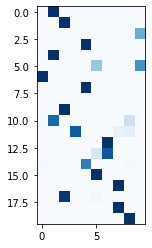

[[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.5       ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.38271605
  0.         0.         0.         0.61728395]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.   

In [75]:
import matplotlib.pyplot as plt 
import numpy as np

myArray = np.zeros((len(plants), len(markets)), dtype=np.float)


for i,p in enumerate(plants):
    for j,m in enumerate(markets): 
        myArray[i][j] = varsDict["X_(\'%s\',_\'%s\')" %(p, m)]/plants["P"+str(i+1)]['Capacity']
plt.imshow(myArray, cmap='Blues', interpolation='nearest')
plt.show()
print(myArray)

In [76]:
TotalCost=0
for i in plants :
    for j in markets :
        index="X_('"+str(i)+"',_'"+str(j)+"')"
        TotalCost+=(freightCost[i][j] + plants[i]['Cost'])*varsDict[index]
print(TotalCost)

16847.0
